In [1]:
import pickle
import warnings
import gc

import matplotlib.pyplot as plt
import mplcursors
import pandas as pd
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

# Load the data

In [2]:
import os
from config import DATA_DIR

data = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
# data = pd.read_csv(os.path.join(DATA_DIR, "train_data_cleaned.csv"))

# Explore the data

In [3]:
print(data.head())

                            Наименование 2022-01-10 2022-01-14 2022-01-21  \
0                   Аллохол, 50 таблеток      99.83     100.21     100.09   
1                             Бананы, кг     104.55     101.13     101.32   
2  Баранина (кроме бескостного мяса), кг     100.25     100.04     100.42   
3                   Бензин автомобильный     100.52     100.06     100.14   
4    Бензин автомобильный марки АИ-92, л     100.51     100.06     100.11   

  2022-01-28 2022-02-04 2022-02-11 2022-02-18 2022-02-25 2022-03-04  ...  \
0      99.79      99.46      99.95      99.96     100.66     102.67  ...   
1     101.76     101.81     102.35      102.2      102.8      107.2  ...   
2     100.32      99.93      100.2     100.36     100.22     100.22  ...   
3     100.18     100.02     100.04     100.06        100     100.04  ...   
4     100.17      99.92     100.04     100.06      99.98        100  ...   

  2024-05-02 2024-05-06 2024-05-13 2024-05-20 2024-05-27 2024-06-03  \
0     100

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Columns: 129 entries, Наименование to 2024-07-01
dtypes: float64(77), object(52)
memory usage: 116.0+ KB
None


In [5]:
print(data.describe())

       2023-01-09  2023-01-16  2023-01-23  2023-01-30  2023-02-06  2023-02-13  \
count  110.000000  110.000000  110.000000  110.000000  110.000000  110.000000   
mean   100.674364  100.274545  100.266545  100.329364  100.454273  100.317636   
std      2.331290    1.172866    0.955569    1.248879    1.738870    1.401263   
min     91.470000   93.660000   99.000000   98.650000   98.990000   98.470000   
25%     99.972500   99.952500   99.930000  100.000000   99.970000   99.940000   
50%    100.095000  100.060000  100.020000  100.060000  100.130000  100.020000   
75%    100.515000  100.320000  100.227500  100.177500  100.310000  100.207500   
max    113.010000  105.410000  106.320000  107.840000  112.710000  110.110000   

       2023-02-20  2023-02-27  2023-03-06  2023-03-13  ...  2024-05-02  \
count  110.000000  110.000000  110.000000  110.000000  ...  110.000000   
mean   100.129091   99.993545  100.020000  100.042909  ...  100.159818   
std      1.097047    0.988824    1.549881    1.2

# Clean and transform the data

In [6]:
# Handle missing values if any
data = data.dropna()

# Extract product names and dates
product_names = data.iloc[:, 0]
price_data = data.iloc[:, 1:]

# Convert the price data to a long format
price_data_long = pd.melt(data, id_vars=['Наименование'], var_name='Date', value_name='Price')

# Rename columns for clarity
price_data_long.columns = ['Product', 'Date', 'Price']

# Convert Date column to datetime format
price_data_long['Date'] = pd.to_datetime(price_data_long['Date'], format='%Y-%m-%d')

# Convert Price column to numeric, forcing errors to NaN
price_data_long['Price'] = pd.to_numeric(price_data_long['Price'], errors='coerce')

# Drop rows with NaN values in Price column
price_data_long = price_data_long.dropna(subset=['Price'])

print(price_data_long.head())
print(price_data_long.tail())

# Saving to file
filename = os.path.join(DATA_DIR, "price_data_long.csv")
price_data_long.to_csv(filename, index=False)

                                 Product       Date   Price
0                   Аллохол, 50 таблеток 2022-01-10   99.83
1                             Бананы, кг 2022-01-10  104.55
2  Баранина (кроме бескостного мяса), кг 2022-01-10  100.25
3                   Бензин автомобильный 2022-01-10  100.52
4    Бензин автомобильный марки АИ-92, л 2022-01-10  100.51
                             Product       Date   Price
13179              Щетка зубная, шт. 2024-07-01   99.96
13180  Электропылесос напольный, шт. 2024-07-01   99.30
13181         Эргоферон, 20 таблеток 2024-07-01   99.57
13182                     Яблоки, кг 2024-07-01  101.54
13183           Яйца куриные, 10 шт. 2024-07-01   99.01


# Preliminary analysis

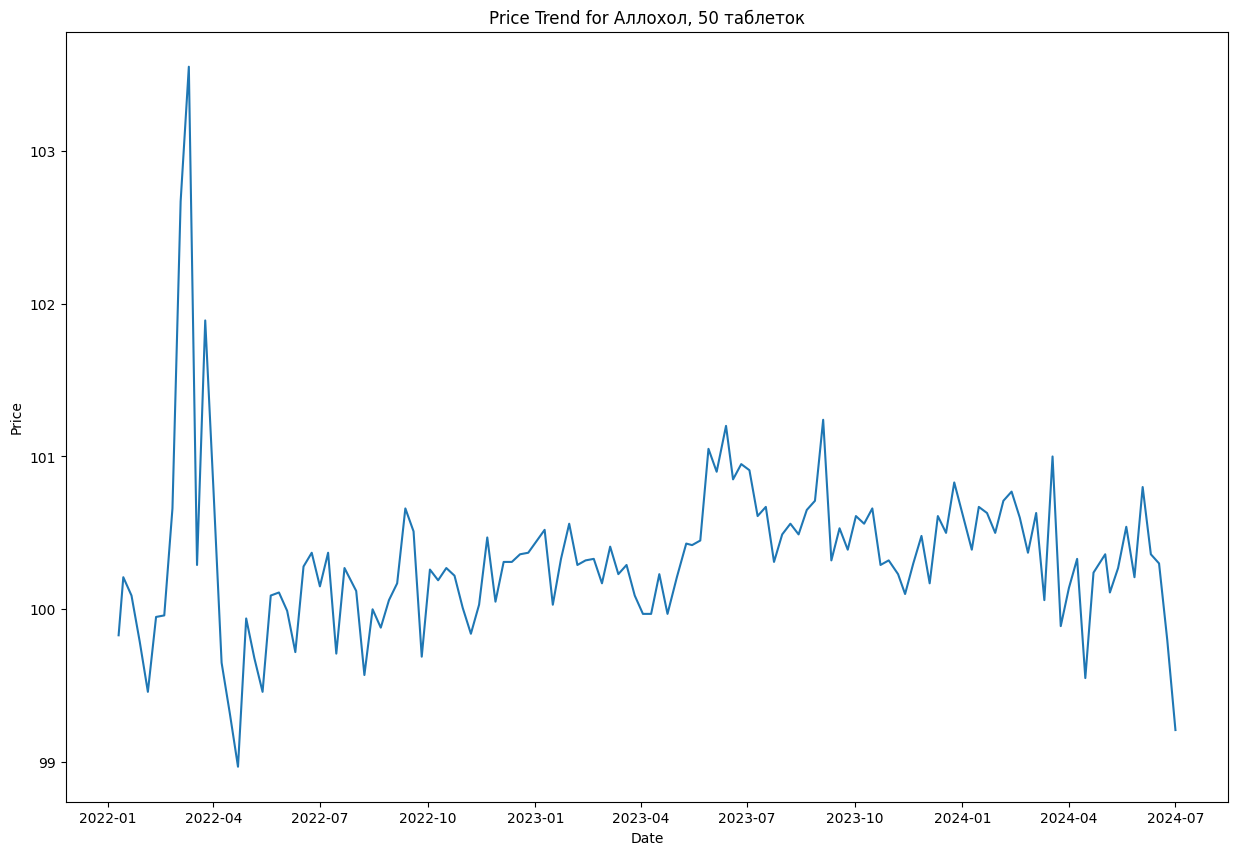

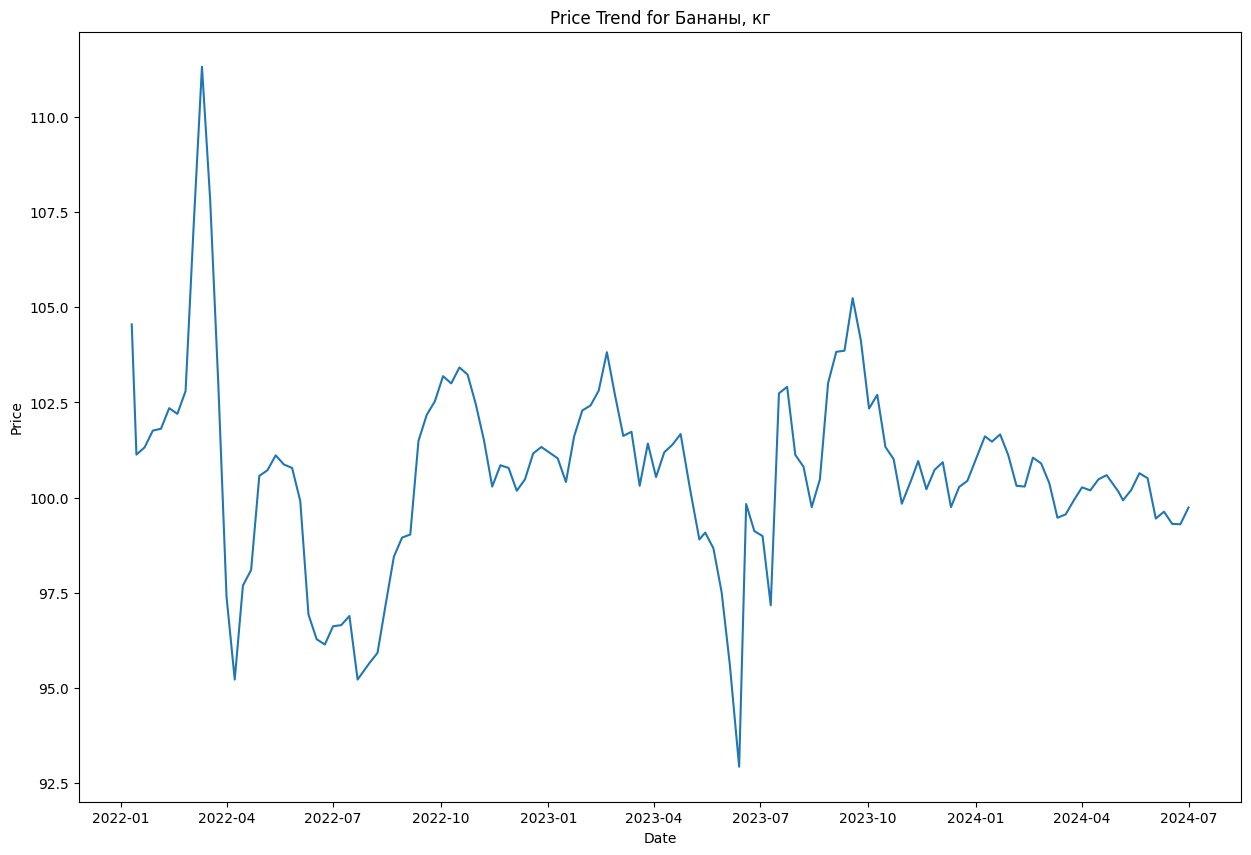

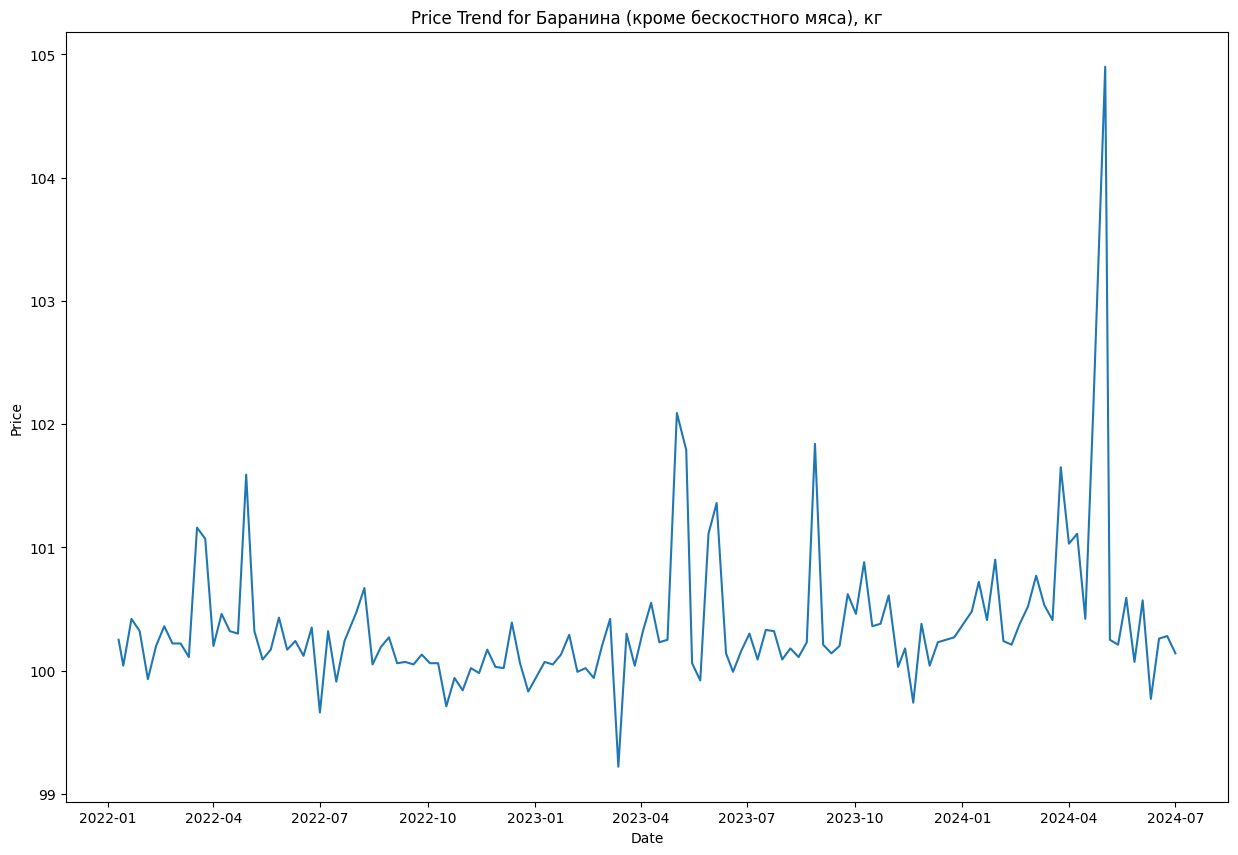

In [7]:
# Plot price trends for each product
for product in price_data_long['Product'].unique()[:3]:
    product_data = price_data_long[price_data_long['Product'] == product]
    plt.figure(figsize=(15, 10))
    plt.plot(product_data['Date'], product_data['Price'])
    plt.title(f'Price Trend for {product}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

# Train-test split

In [8]:
# Split the data into training and testing sets
train_data = price_data_long[price_data_long['Date'] <= '2023-11-09']
test_data = price_data_long[price_data_long['Date'] > '2023-11-09']

# train_data = price_data_long[price_data_long['Date'] < '2022-01-21']
# test_data = price_data_long[price_data_long['Date'] >= '2022-01-21']

In [9]:
print("Train data:")
print(train_data.head())
print(train_data.tail())

# filename = os.path.join(DATA_DIR, "train.csv")
# train_data.to_csv(filename)

Train data:
                                 Product       Date   Price
0                   Аллохол, 50 таблеток 2022-01-10   99.83
1                             Бананы, кг 2022-01-10  104.55
2  Баранина (кроме бескостного мяса), кг 2022-01-10  100.25
3                   Бензин автомобильный 2022-01-10  100.52
4    Бензин автомобильный марки АИ-92, л 2022-01-10  100.51
                            Product       Date   Price
9780              Щетка зубная, шт. 2023-11-07   99.80
9781  Электропылесос напольный, шт. 2023-11-07  100.58
9782         Эргоферон, 20 таблеток 2023-11-07  100.34
9783                     Яблоки, кг 2023-11-07   99.66
9784           Яйца куриные, 10 шт. 2023-11-07  102.42


In [10]:
print("Test data:")
print(test_data.head())
print(test_data.tail())

# filename = os.path.join(DATA_DIR, "test.csv")
# test_data.to_csv(filename)

Test data:
                                    Product       Date   Price
9785                   Аллохол, 50 таблеток 2023-11-13  100.10
9786                             Бананы, кг 2023-11-13  100.96
9787  Баранина (кроме бескостного мяса), кг 2023-11-13  100.18
9788                   Бензин автомобильный 2023-11-13   99.85
9789    Бензин автомобильный марки АИ-92, л 2023-11-13   99.83
                             Product       Date   Price
13179              Щетка зубная, шт. 2024-07-01   99.96
13180  Электропылесос напольный, шт. 2024-07-01   99.30
13181         Эргоферон, 20 таблеток 2024-07-01   99.57
13182                     Яблоки, кг 2024-07-01  101.54
13183           Яйца куриные, 10 шт. 2024-07-01   99.01


# Get data to build model on and forecast for the Next 6 Months

In [11]:
# products = train_data["Product"]
# product = products[2]
# 
# 
# def make_forecast(product_name: str):
#     product_train_data = train_data[train_data['Product'] == product_name]
#     product_test_data = test_data[test_data['Product'] == product_name]
# 
#     # Sort the data by date
#     product_train_data = product_train_data.sort_values(by='Date')
#     product_test_data = product_test_data.sort_values(by='Date')
# 
#     print(f"Plotting for {product_name}")
# 
#     # Combine train and test data for plotting
#     combined_data = pd.concat([product_train_data, product_test_data]).sort_values(by='Date')
# 
#     # Build the model
#     model = ExponentialSmoothing(combined_data['Price'], trend='add', seasonal='add', seasonal_periods=12)
#     model_fit = model.fit()
# 
#     # Save the model to a file
#     model_filename = f"{product_name.replace(' ', '_')}_model.pkl"
#     model_path = os.path.join(DATA_DIR, "trained_models", model_filename)
#     with open(model_filename, 'wb') as f:
#         pickle.dump(model_fit, f)
# 
#     # Forecast for the next 28 weeks
#     forecast_horizon = 28
#     forecast_dates = pd.date_range(start=combined_data['Date'].max() + pd.Timedelta(days=7), periods=forecast_horizon,
#                                    freq='W')
#     forecast = model_fit.forecast(steps=forecast_horizon)
# 
#     # Calculate evaluation metrics
#     actual = combined_data["Price"]
#     in_sample_forecast = model_fit.fittedvalues
#     mae = mean_absolute_error(actual, in_sample_forecast)
#     print(f"In-sample Mean Absolute Error: {mae}")
# 
#     # Percentage MAE
#     percentage_mae = mae / actual.mean() * 100
#     print(f"In-sample Percentage Mean Absolute Error: {percentage_mae:.2f}%")
# 
#     # Plot the data and forecast
#     plt.figure(figsize=(14, 7))
# 
#     # Plot historical data
#     plt.plot(combined_data['Date'], combined_data['Price'], label='Historical Data', marker='o')
# 
#     # Plot in-sample forecast
#     plt.plot(combined_data['Date'], in_sample_forecast, label='In-sample Forecast', linestyle='--')
# 
#     # Plot out-of-sample forecast
#     plt.plot(forecast_dates, forecast, label='Next 28 Weeks Forecast', linestyle='--', marker='o')
# 
#     plt.legend()
#     plt.title(f'Historical Data and Forecast for {product_name}')
#     plt.xlabel('Date')
#     plt.ylabel('Price')
#     plt.grid(True)
# 
#     # Add more details and a grid to the plot
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# 
#     # Add zooming capability
#     mplcursors.cursor(hover=True)
# 
#     plt.show()
# 
# 
# make_forecast(product)

In [12]:
from services.tools import slugify_cyrillic_word


def make_forecast(product_name: str, use_train_test_split=True):
    product_train_data = train_data[train_data['Product'] == product_name]
    product_test_data = test_data[test_data['Product'] == product_name]

    # Sort the data by date
    product_train_data = product_train_data.sort_values(by='Date')
    product_test_data = product_test_data.sort_values(by='Date')

    print(f"Plotting for {product_name}")

    if use_train_test_split:
        # Use only training data for model fitting
        model = ExponentialSmoothing(product_train_data['Price'], trend='add', seasonal='add', seasonal_periods=12)
        model_fit = model.fit()

        # In-sample forecast (on training data)
        in_sample_forecast = model_fit.fittedvalues

        # Out-of-sample forecast (on test data)
        out_of_sample_forecast = model_fit.forecast(steps=len(product_test_data))

        # Calculate evaluation metrics
        train_mae = mean_absolute_error(product_train_data['Price'], in_sample_forecast)
        test_mae = mean_absolute_error(product_test_data['Price'], out_of_sample_forecast)

        print(f"Train MAE: {train_mae}")
        print(f"Test MAE: {test_mae}")

        # Plot
        plt.figure(figsize=(14, 7))
        plt.plot(product_train_data['Date'], product_train_data['Price'], label='Training Data', marker='o')
        plt.plot(product_test_data['Date'], product_test_data['Price'], label='Test Data', marker='o')
        plt.plot(product_train_data['Date'], in_sample_forecast, label='In-sample Forecast', linestyle='--')
        plt.plot(product_test_data['Date'], out_of_sample_forecast, label='Out-of-sample Forecast', linestyle='--')
    else:
        # Use all data for model fitting
        combined_data = pd.concat([product_train_data, product_test_data]).sort_values(by='Date')
        model = ExponentialSmoothing(combined_data['Price'], trend='add', seasonal='add', seasonal_periods=12)
        model_fit = model.fit()

        # In-sample forecast
        in_sample_forecast = model_fit.fittedvalues

        # Calculate evaluation metrics
        mae = mean_absolute_error(combined_data['Price'], in_sample_forecast)
        print(f"In-sample MAE: {mae}")

        # Plot
        plt.figure(figsize=(14, 7))
        plt.plot(combined_data['Date'], combined_data['Price'], label='Historical Data', marker='o')
        plt.plot(combined_data['Date'], in_sample_forecast, label='In-sample Forecast', linestyle='--')

    # Forecast for the next 28 weeks
    forecast_horizon = 28
    last_date = product_test_data['Date'].max() if use_train_test_split else combined_data['Date'].max()
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Plot future forecast
    plt.plot(forecast_dates, forecast, label='Next 28 Weeks Forecast', linestyle='--', marker='o')

    plt.legend()
    plt.title(f'Historical Data and Forecast for {product_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    mplcursors.cursor(hover=True)
    plt.show()

    # Save the model
    model_filename = f"{slugify_cyrillic_word(product_name)}_model.pkl"
    model_path = os.path.join(DATA_DIR, "trained_models", model_filename)
    with open(model_path, 'wb') as f:
        pickle.dump(model_fit, f)


products = train_data["Product"]



# Use train test split

Plotting for Аллохол, 50 таблеток
Train MAE: 0.3238273421152673
Test MAE: 0.3300237593041277


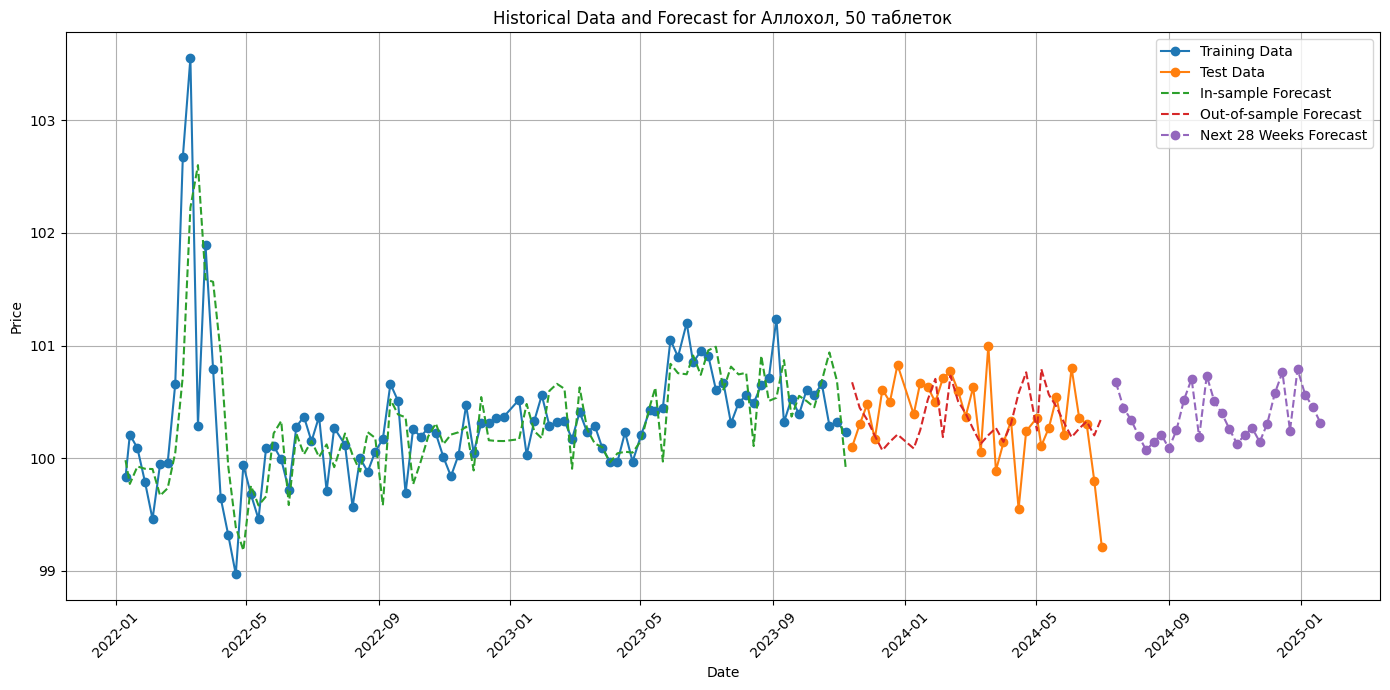

Plotting for Бананы, кг
Train MAE: 1.155225936137592
Test MAE: 1.2265881148891185


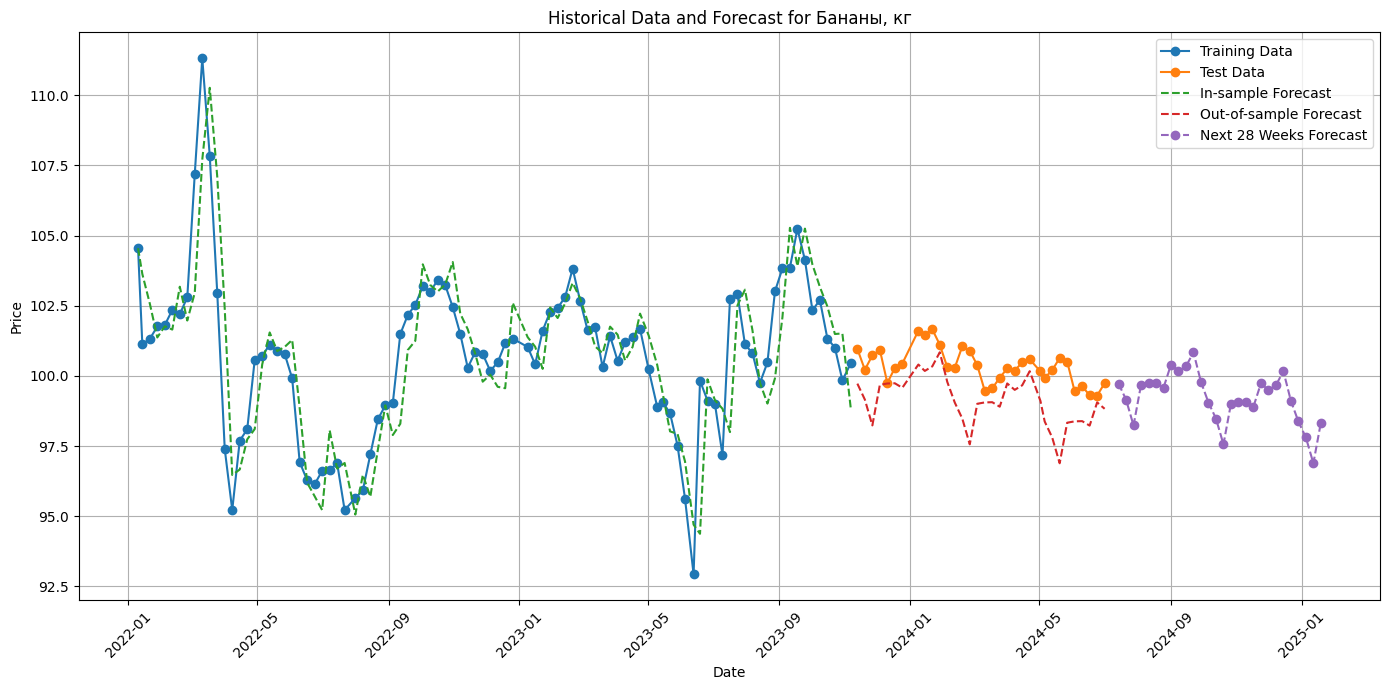

Plotting for Баранина (кроме бескостного мяса), кг
Train MAE: 0.2913613775731809
Test MAE: 0.5078719569272607


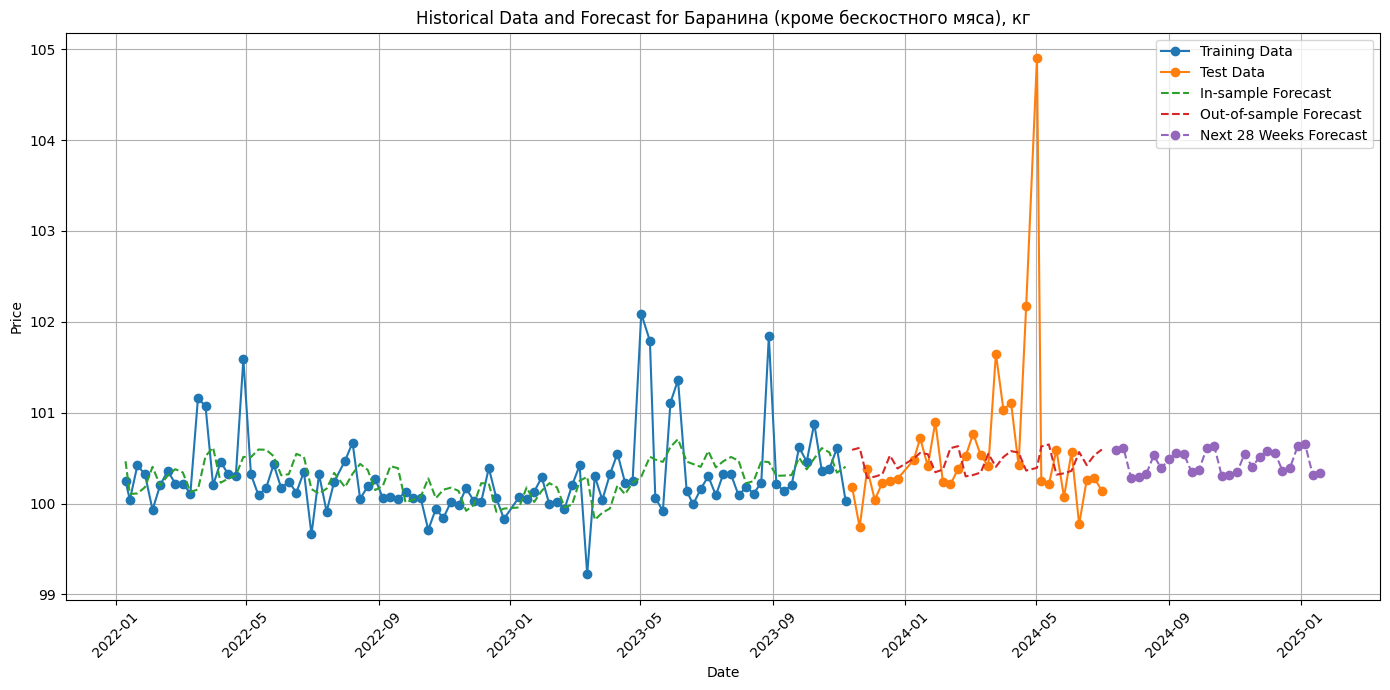

Plotting for Бензин автомобильный
Train MAE: 0.06882309720291759
Test MAE: 0.4484818741635987


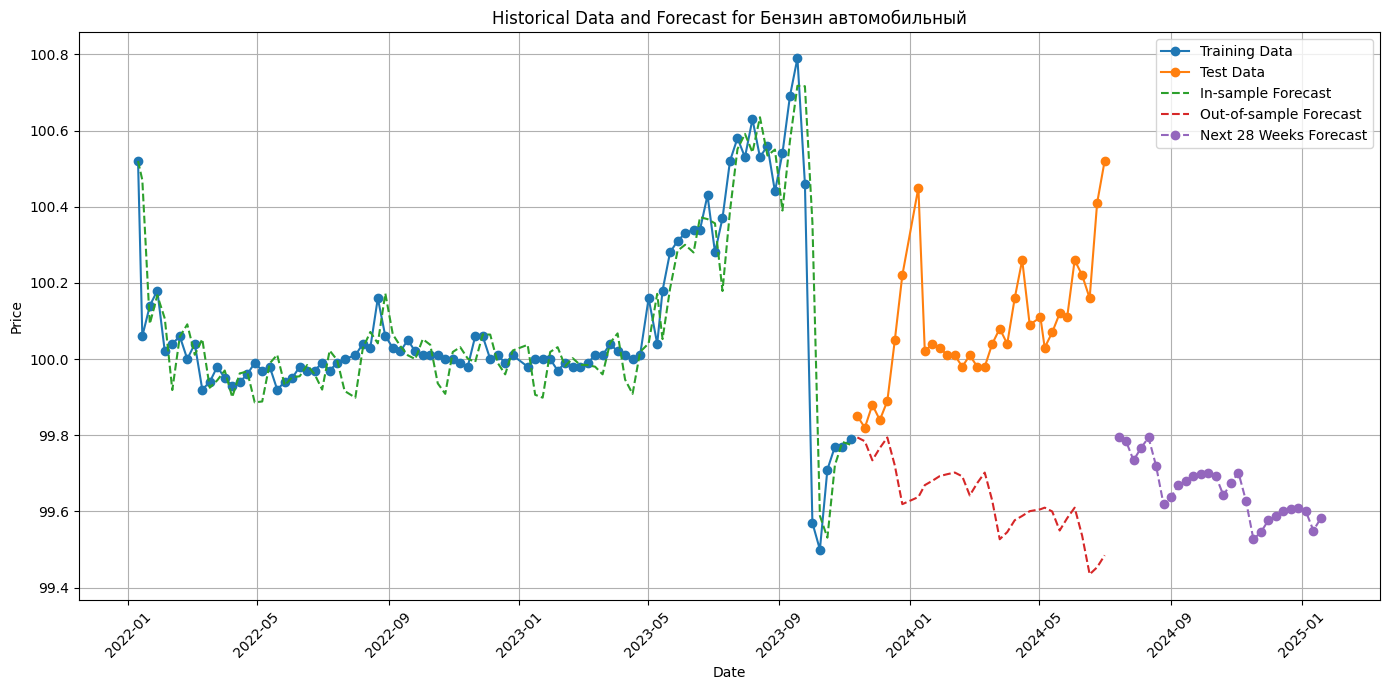

Plotting for Бензин автомобильный марки АИ-92, л
Train MAE: 0.07030238338507756
Test MAE: 0.44312109533116395


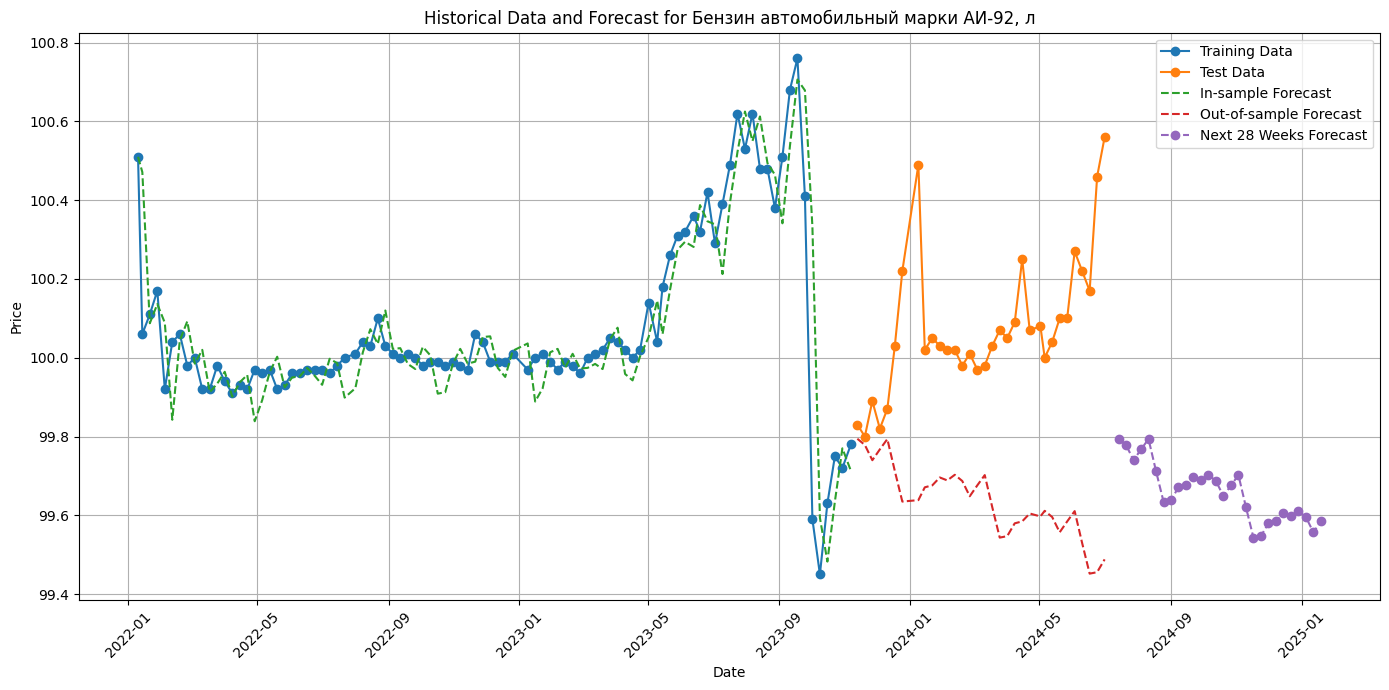

Plotting for Бензин автомобильный марки АИ-95, л
Train MAE: 0.072541415971244
Test MAE: 0.5117574893724445


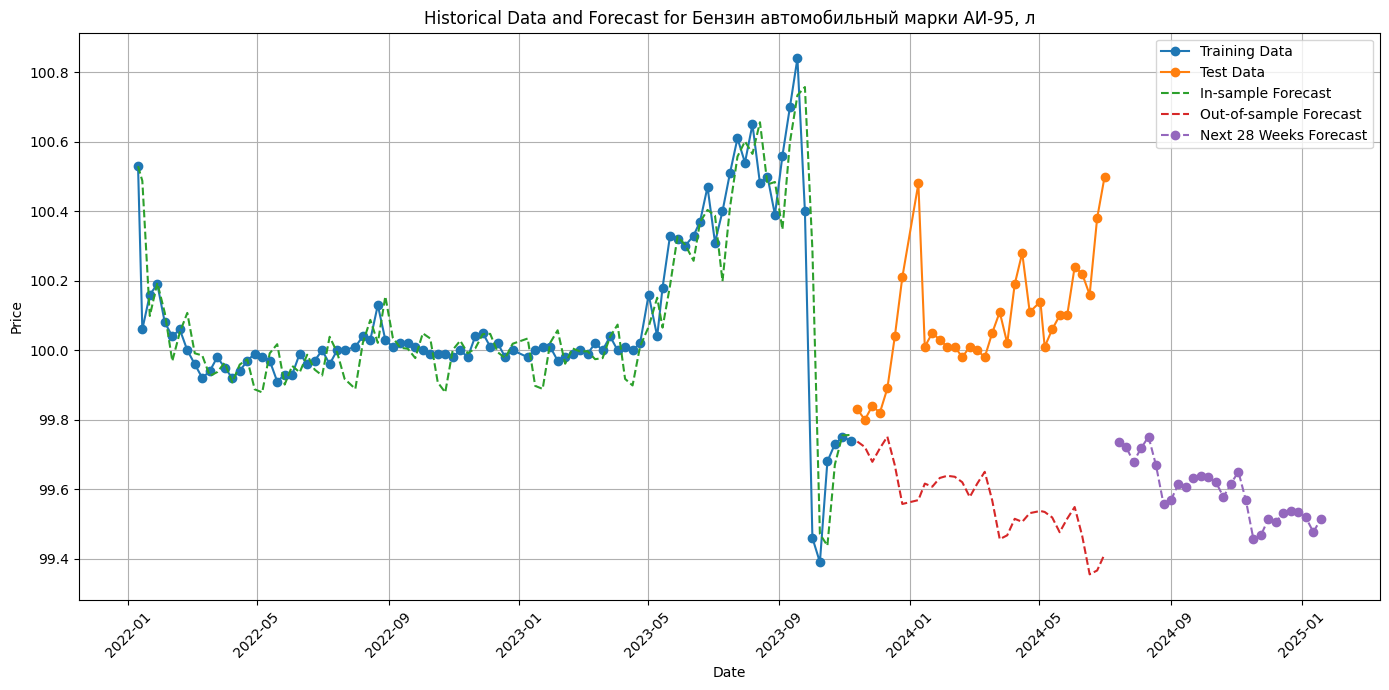

Plotting for Бензин автомобильный марки АИ-98 и выше, л
Train MAE: 0.08472992106180022
Test MAE: 0.24898377106684288


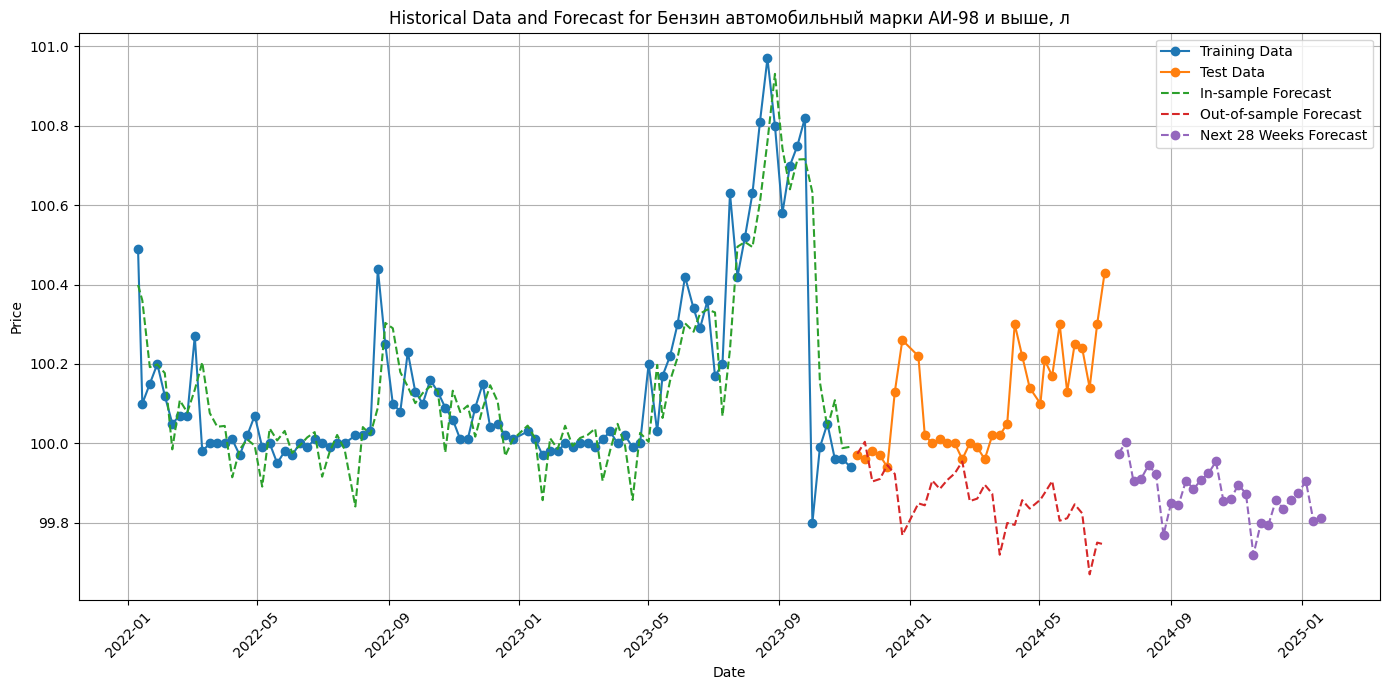

Plotting for Брюки для детей школьного возраста из джинсовой ткани, шт.
Train MAE: 0.2935057289468498
Test MAE: 0.28202867814761823


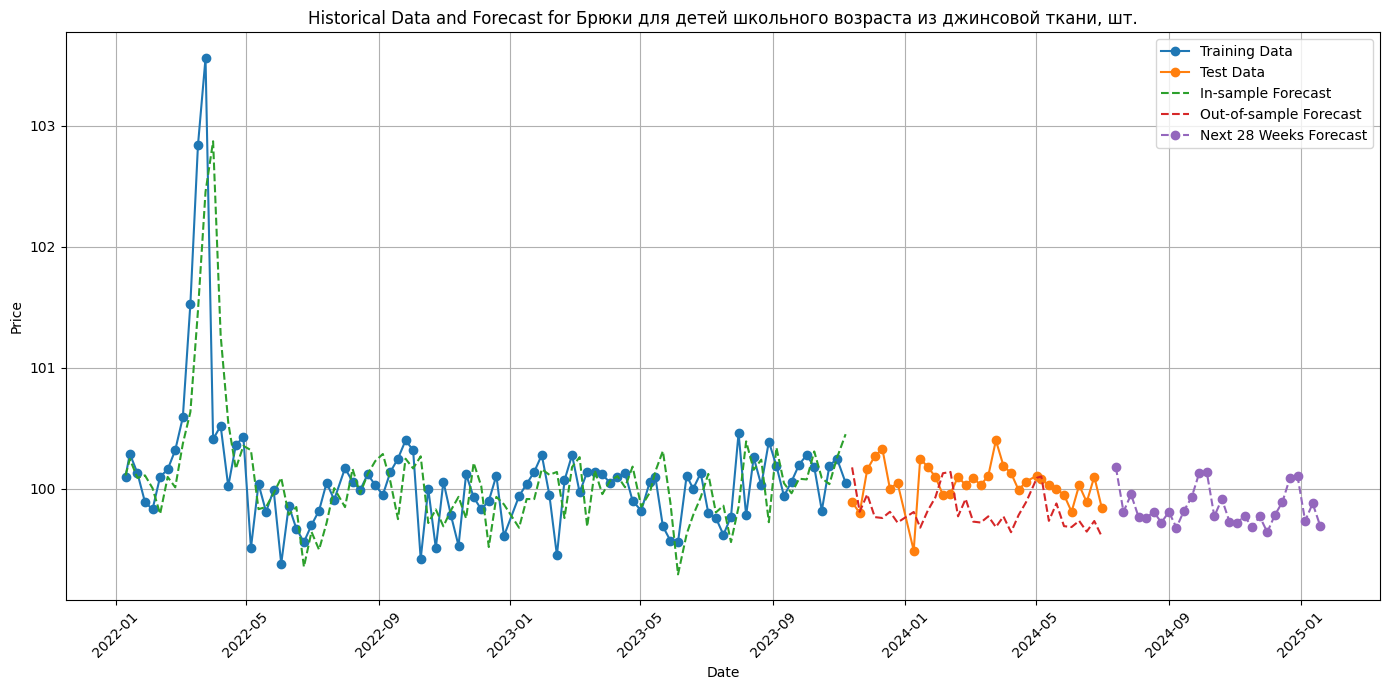

Plotting for Бумага туалетная, рулон
Train MAE: 0.2630834711064713
Test MAE: 0.23892347620536533


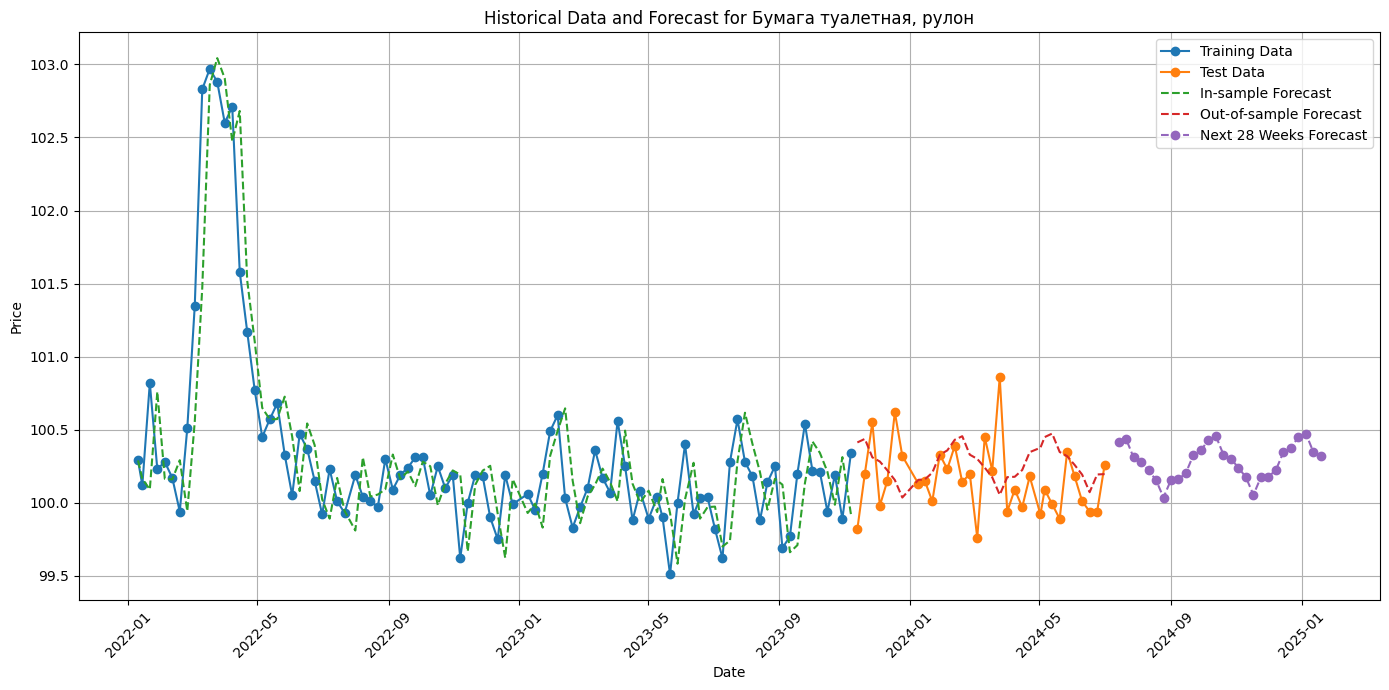

Plotting for Валидол, 60 мг, 10 таблеток
Train MAE: 0.4199333748781934
Test MAE: 0.5188696607377593


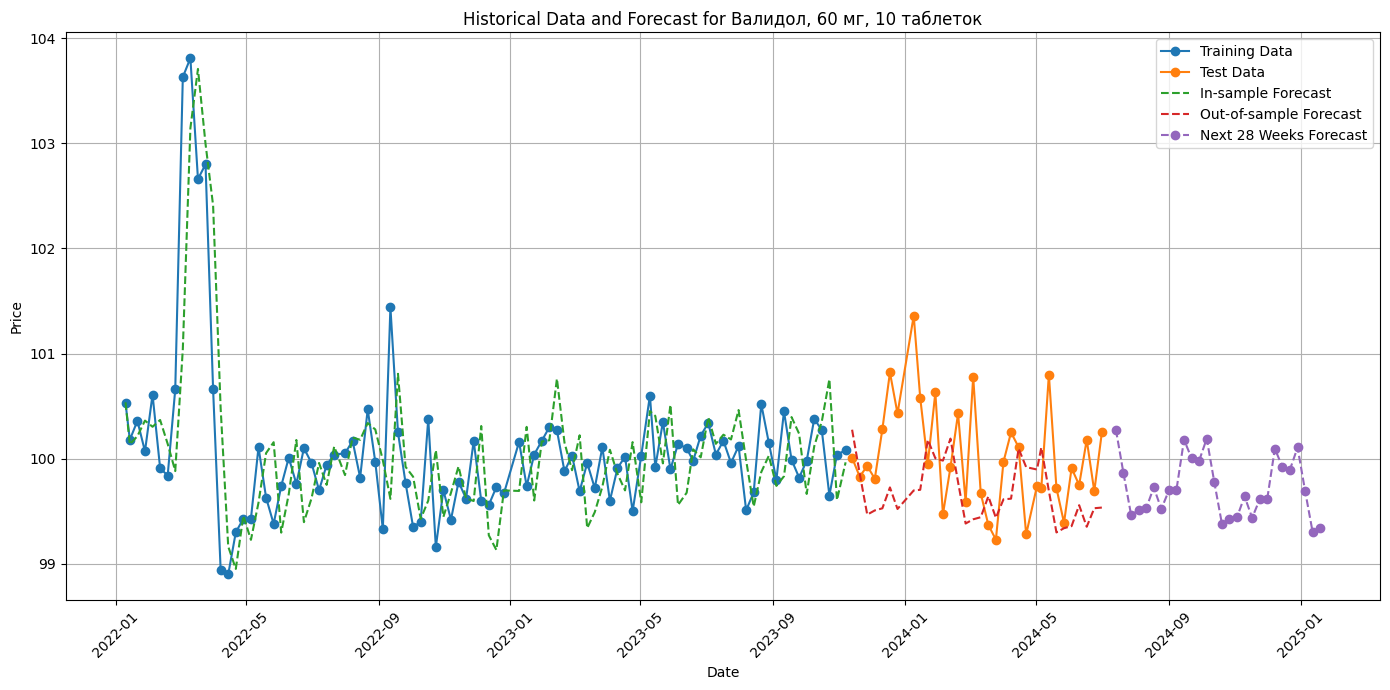

In [13]:
for product in products[:10]:
    make_forecast(product, use_train_test_split=True)
    gc.collect()

# NOT use train test split

Plotting for Аллохол, 50 таблеток
In-sample MAE: 0.31424276615889446


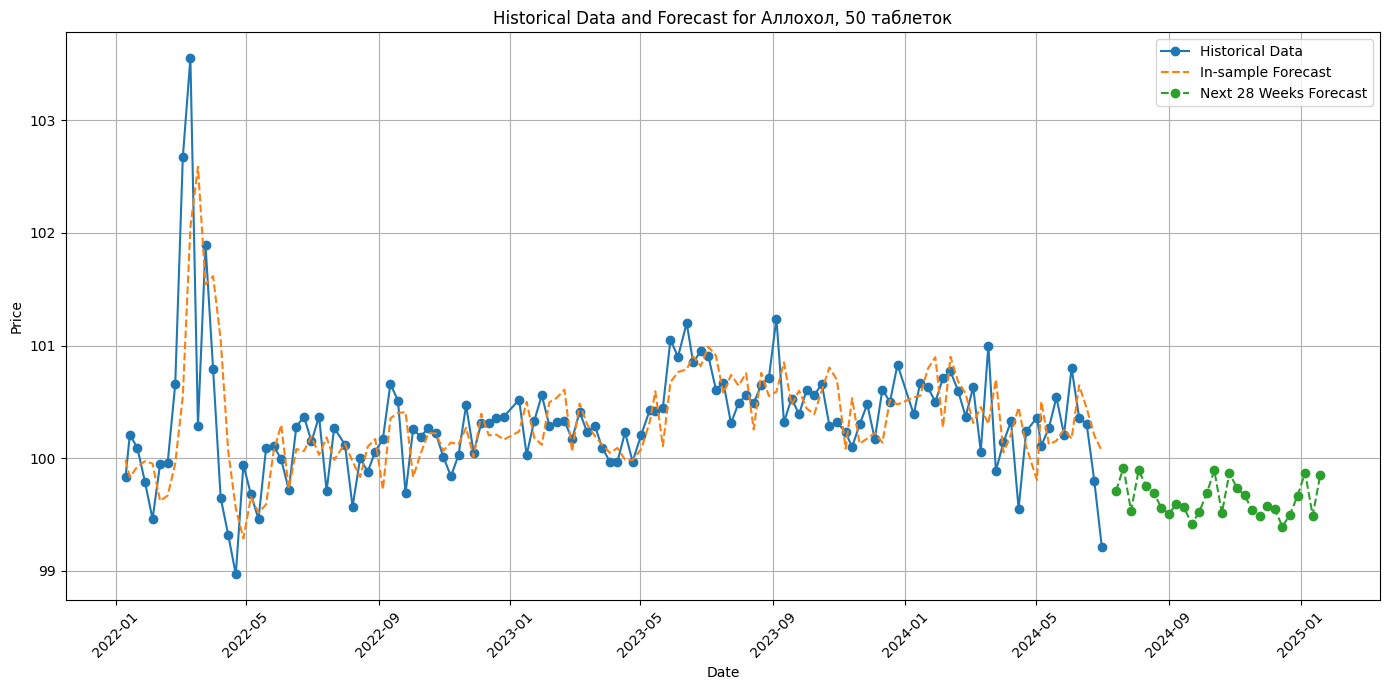

Plotting for Бананы, кг
In-sample MAE: 0.9804915864795266


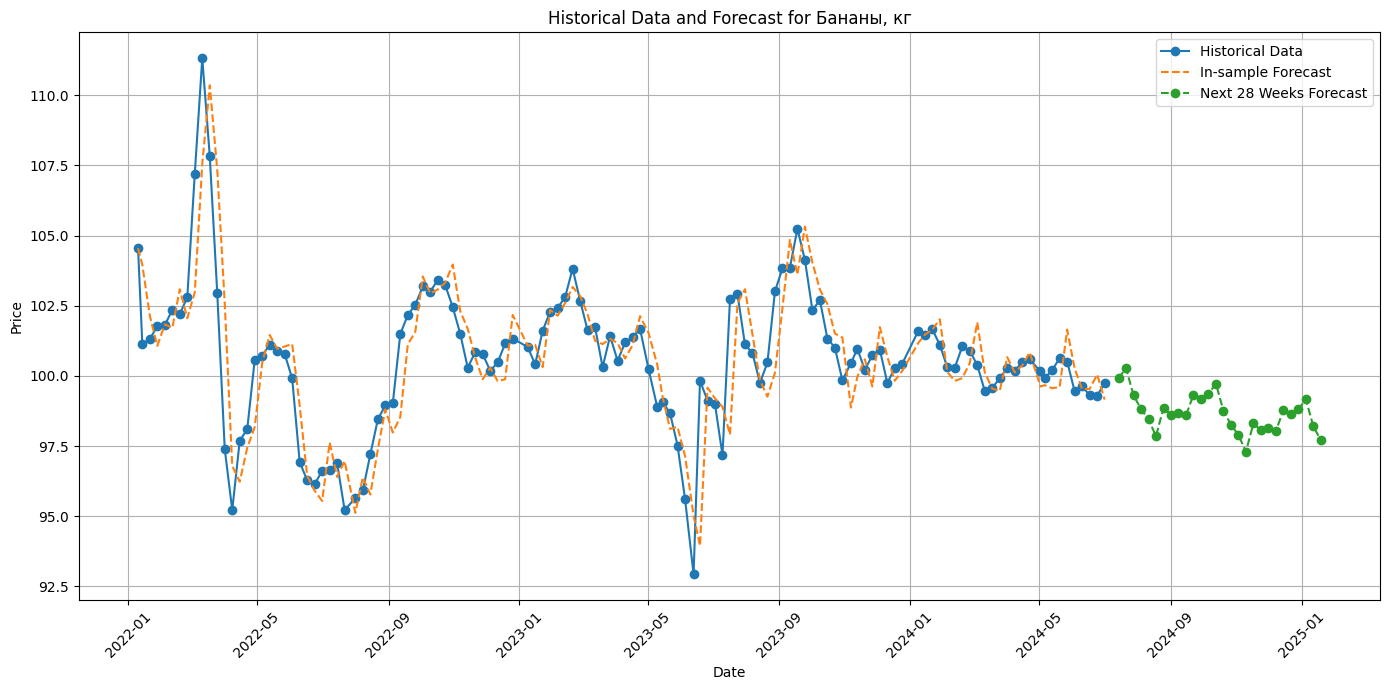

Plotting for Баранина (кроме бескостного мяса), кг
In-sample MAE: 0.36420305921745544


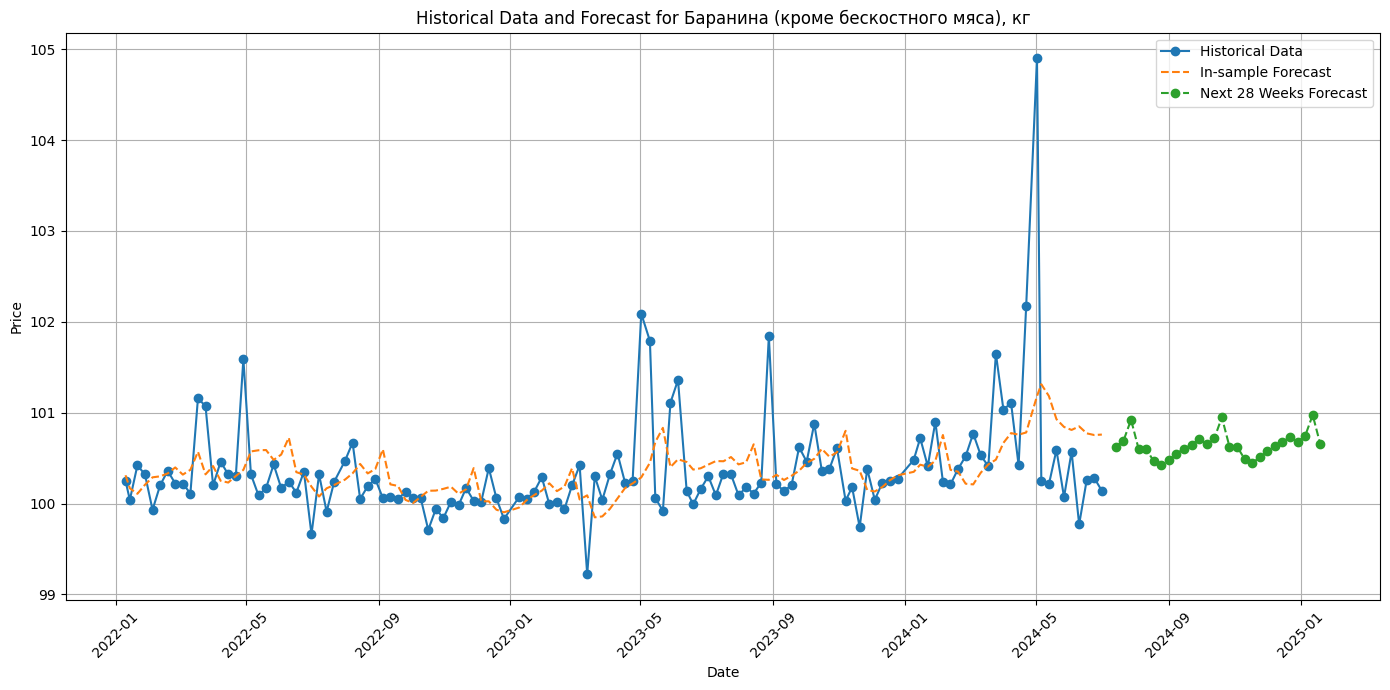

Plotting for Бензин автомобильный
In-sample MAE: 0.06998169605781146


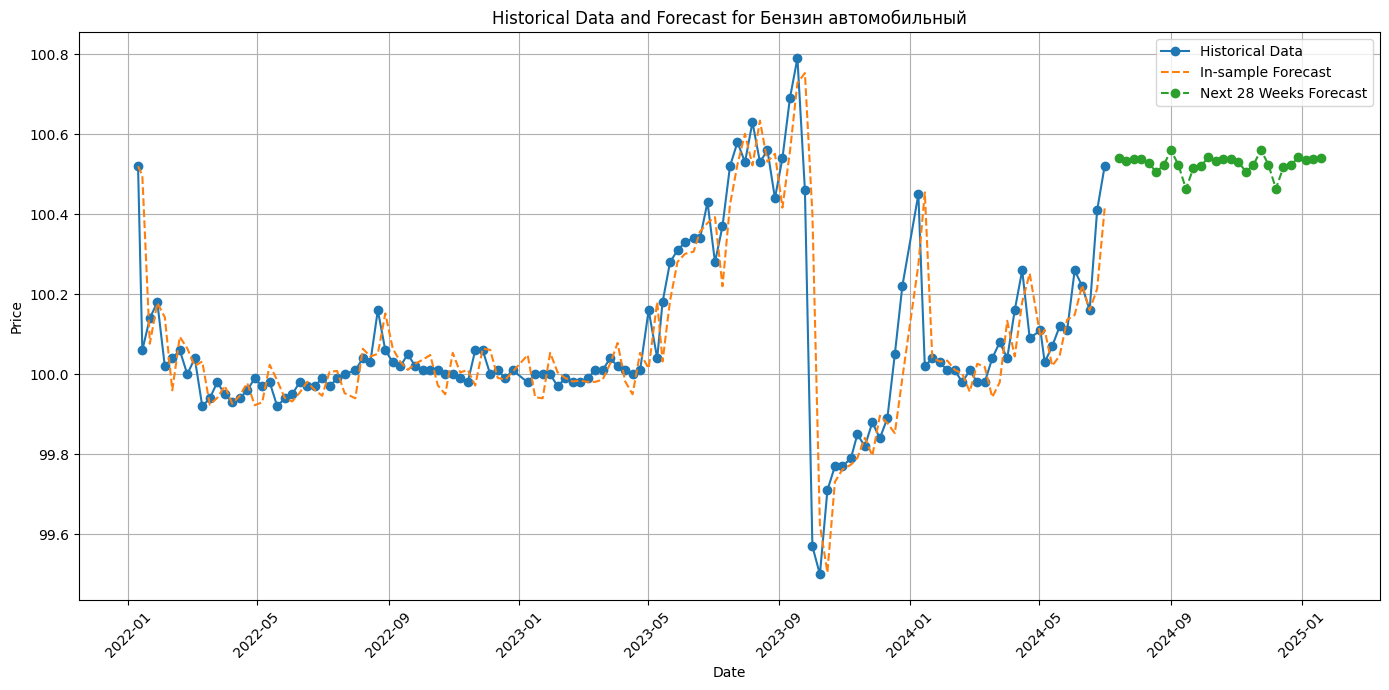

Plotting for Бензин автомобильный марки АИ-92, л
In-sample MAE: 0.07215115252354165


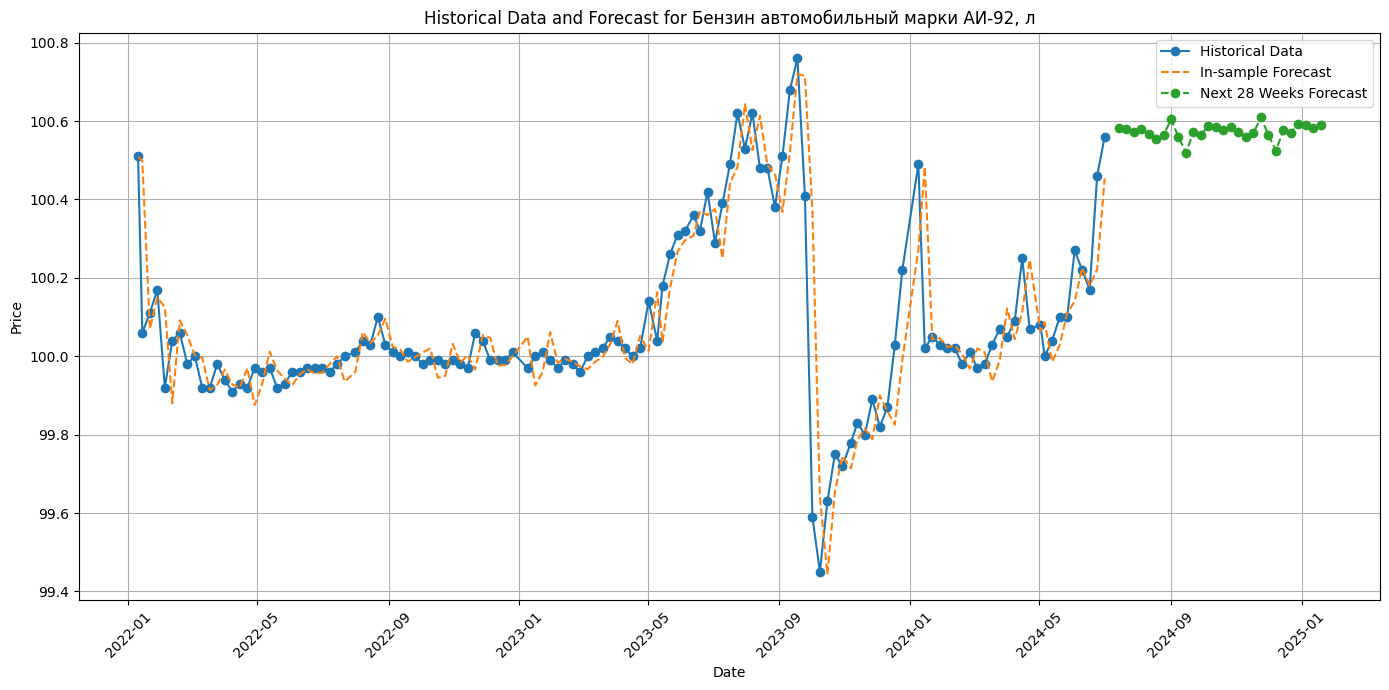

Plotting for Бензин автомобильный марки АИ-95, л
In-sample MAE: 0.0755890885846342


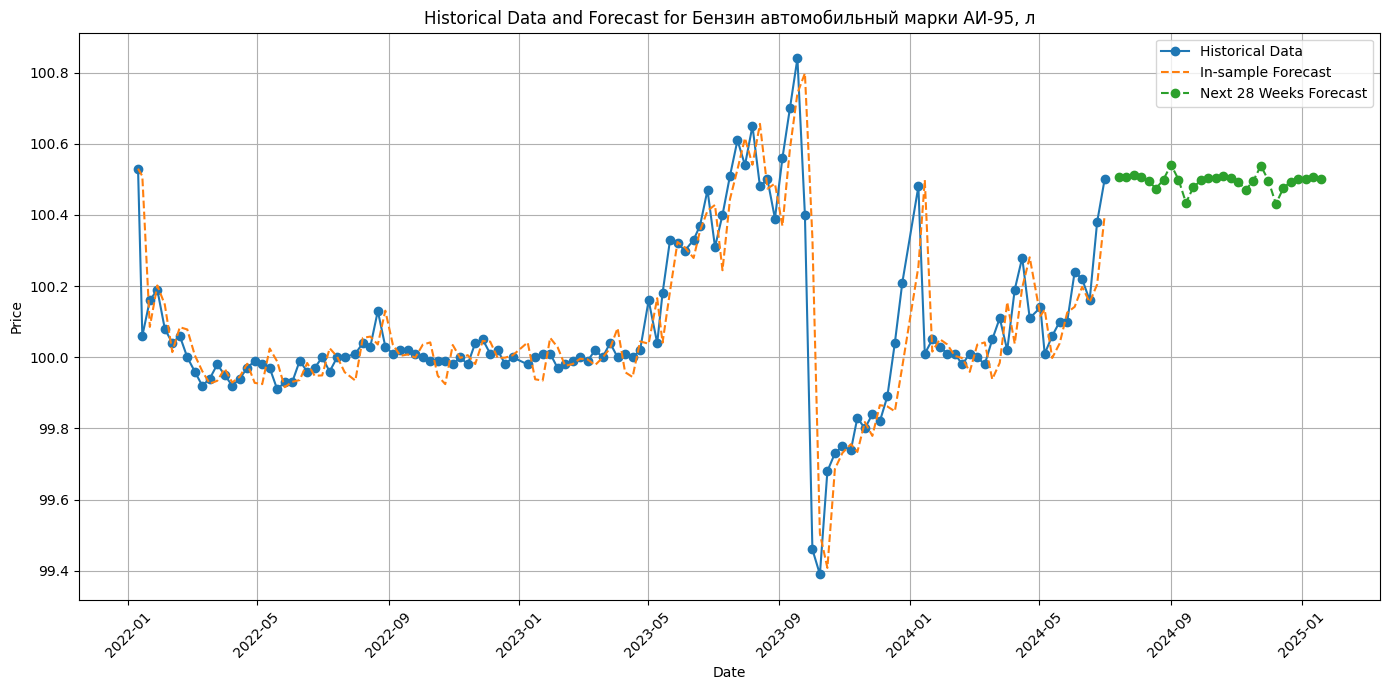

Plotting for Бензин автомобильный марки АИ-98 и выше, л
In-sample MAE: 0.07995619415944222


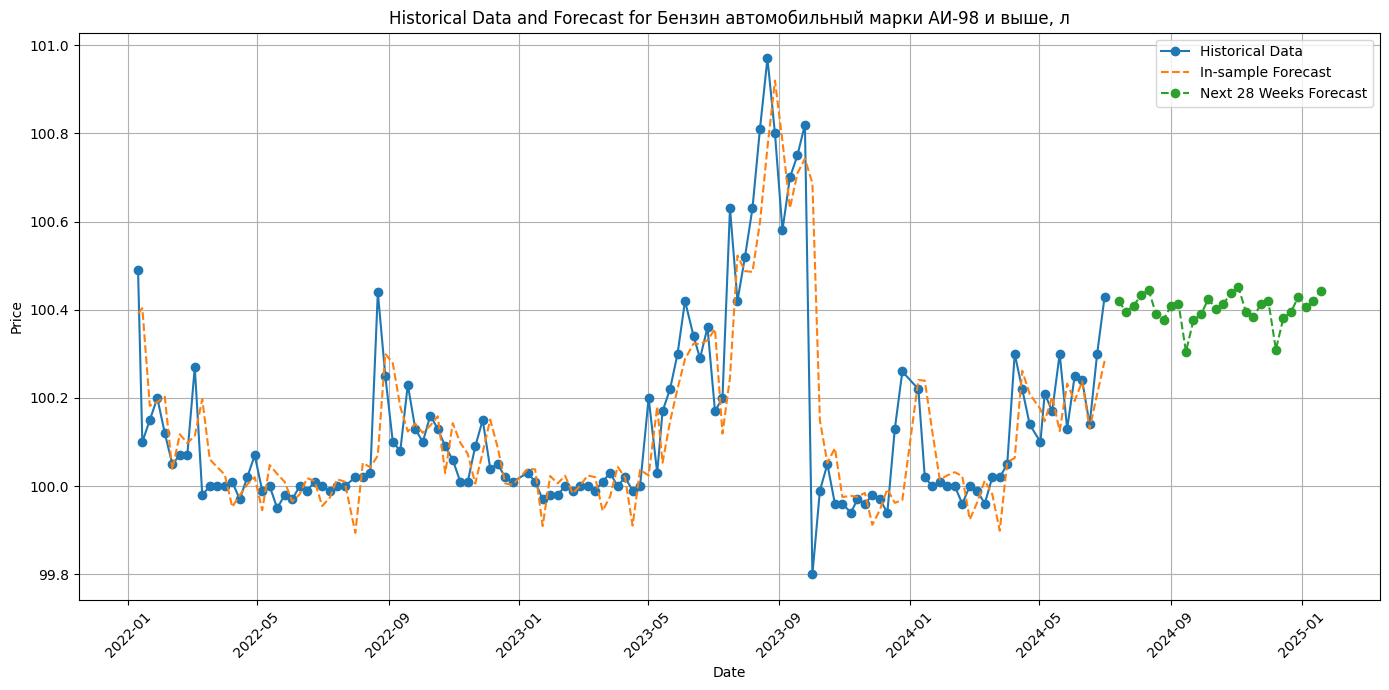

Plotting for Брюки для детей школьного возраста из джинсовой ткани, шт.
In-sample MAE: 0.2592086967325703


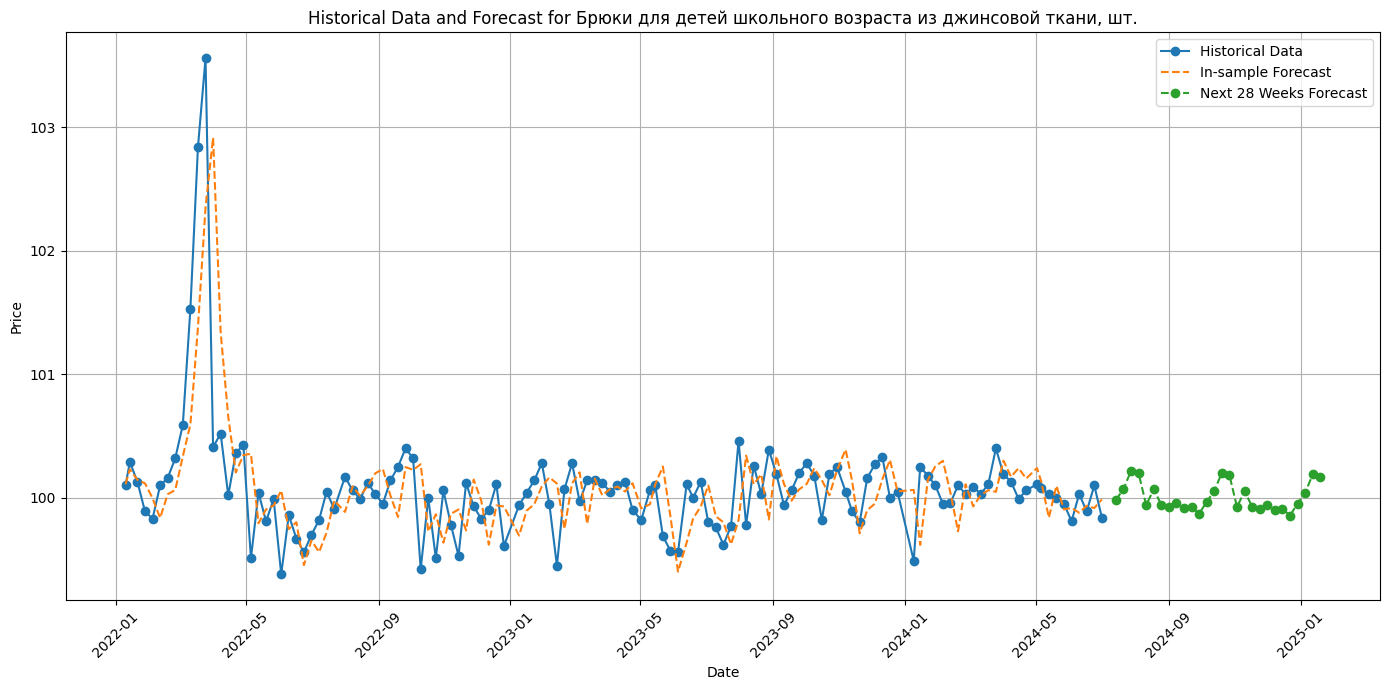

Plotting for Бумага туалетная, рулон
In-sample MAE: 0.2623179312713185


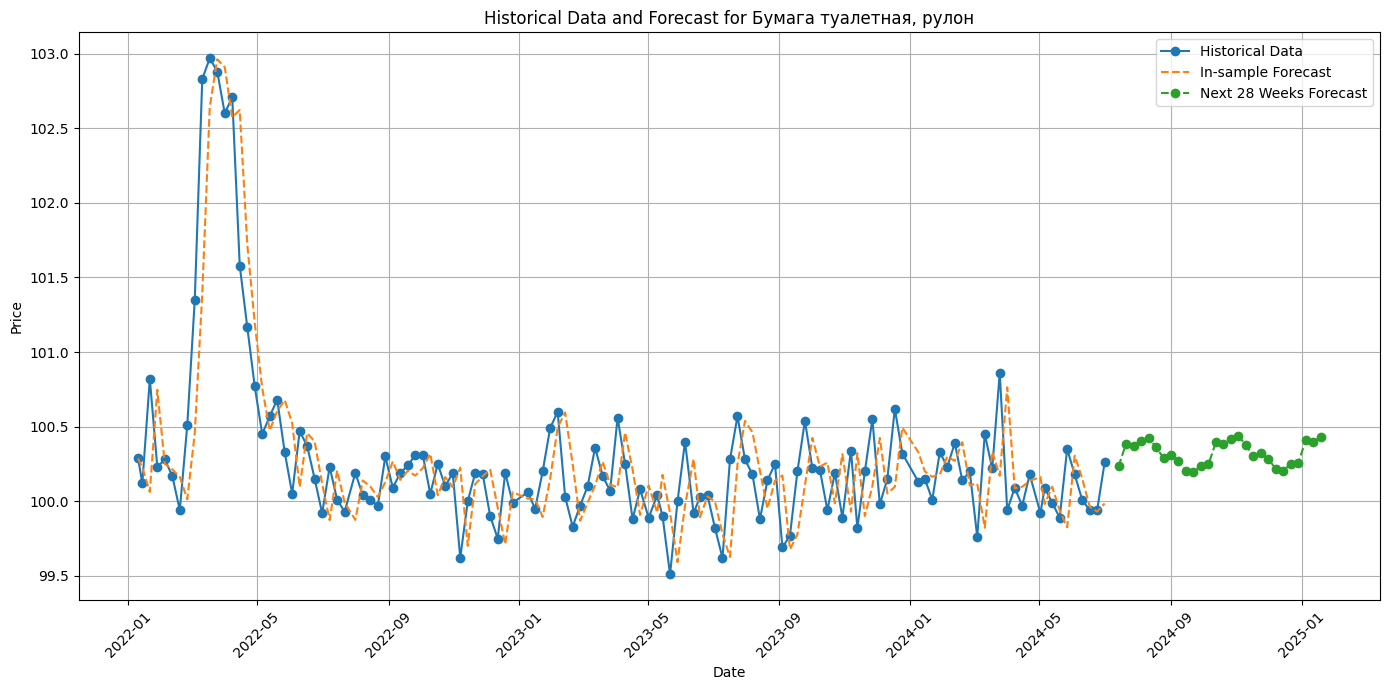

Plotting for Валидол, 60 мг, 10 таблеток
In-sample MAE: 0.4275532272498279


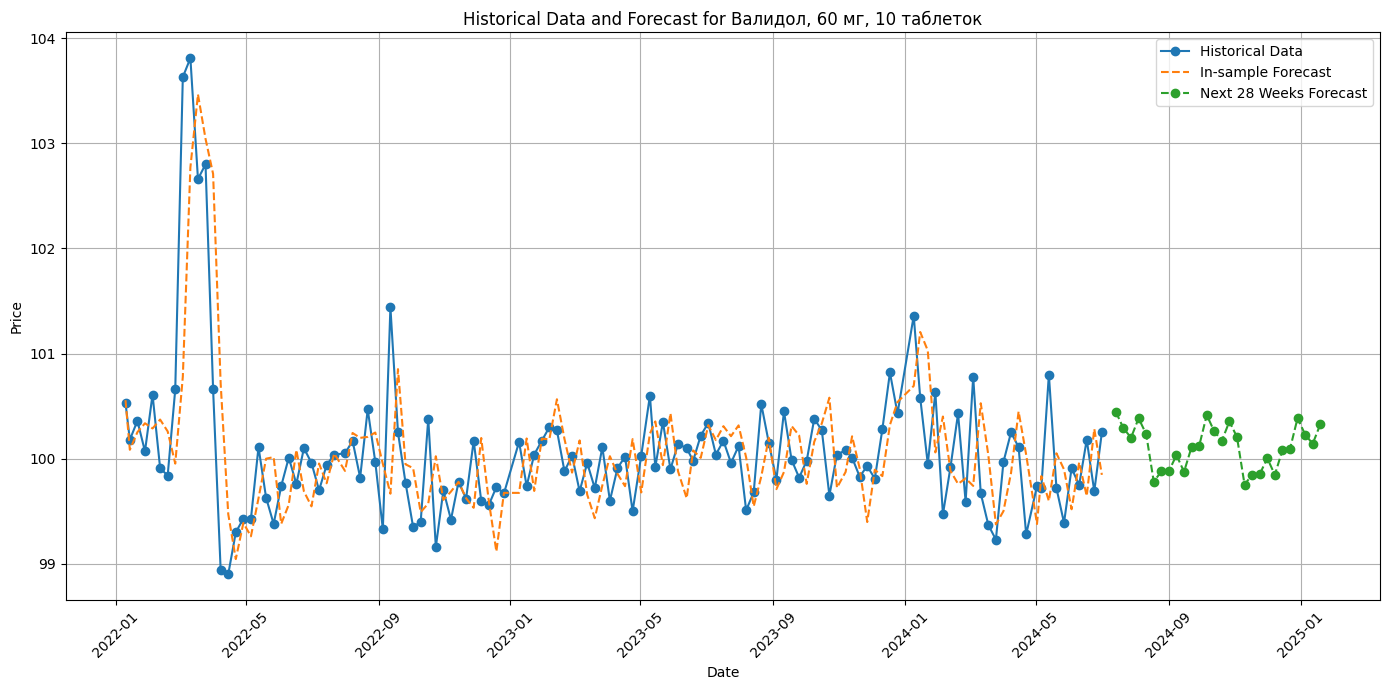

In [14]:
for product in products[:10]:
    make_forecast(product, use_train_test_split=False)
    gc.collect()